In [25]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as f
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from transformers import VisionEncoderDecoderModel,ViTFeatureExtractor,ViTImageProcessor
from transformers import GPT2Config,AutoTokenizer
from transformers import Seq2SeqTrainer,Seq2SeqTrainingArguments
import nltk
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [26]:
# Define constants
Encoder = "google/vit-base-patch16-224"
Decoder = "bert-base-uncased"
BATCH_SIZE = 8
EPOCHS = 6
Images_path = "/kaggle/input/flickr8k/Images"

In [27]:
# Load datasets
ImgNames_Captions = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
ImgNames_Captions.shape

(40455, 2)

In [28]:
len(os.listdir("/kaggle/input/flickr8k/Images"))

8091

In [29]:
train, test = train_test_split(ImgNames_Captions, test_size=0.1)
test, validation = train_test_split(test, test_size=0.5)

In [30]:
train.shape, test.shape, validation.shape

((36409, 2), (2023, 2), (2023, 2))

In [31]:
feature_extractor = ViTImageProcessor.from_pretrained(Encoder)
tokenizer = AutoTokenizer.from_pretrained(Decoder)

In [32]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [33]:
class DataSet(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, maxlen):
        self.df = df
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = maxlen

    def __len__(self,):
        return len(self.df)


    def __getitem__(self, idx):
      caption = self.df.caption.iloc[idx]
      image = self.df.image.iloc[idx]
      img_path = os.path.join(self.root_dir, image)
      img = Image.open(img_path).convert("RGB")
      pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values

      # Tokenize the caption and get attention mask
      tokenized_caption = self.tokenizer(caption, padding='max_length', max_length=self.max_length, return_tensors="pt")
      captions = tokenized_caption.input_ids.squeeze()
      attention_mask = tokenized_caption.attention_mask.squeeze()

      # Replace padding token ids with -100
      labels = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions.tolist()]

      encoding = {
          "pixel_values": pixel_values.squeeze(),
          "labels": torch.tensor(labels),
          "attention_mask": attention_mask
      }
      return encoding


In [34]:
maxlen = max(len(tokenizer(caption)["input_ids"]) for caption in ImgNames_Captions["caption"])
maxlen

42

In [35]:
# Create datasets
train_dataset = DataSet(train, Images_path, tokenizer, feature_extractor, maxlen)
validation_dataset = DataSet(validation, Images_path, tokenizer, feature_extractor, maxlen)
test_dataset = DataSet(test, Images_path, tokenizer, feature_extractor, maxlen)

In [36]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(36409, 2023, 2023)

In [37]:
train_dataset[0]

{'pixel_values': tensor([[[-0.2706, -0.2941, -0.3333,  ..., -0.2863, -0.3255, -0.3412],
          [-0.2706, -0.3020, -0.3490,  ..., -0.2863, -0.3647, -0.3333],
          [-0.2627, -0.2627, -0.3098,  ..., -0.2784, -0.3098, -0.3098],
          ...,
          [ 0.0431, -0.0510,  0.1059,  ..., -0.2784, -0.2314, -0.2471],
          [-0.0039,  0.0275, -0.0588,  ..., -0.2314, -0.1608, -0.2157],
          [ 0.0431, -0.0118, -0.1137,  ...,  0.0196,  0.0667,  0.0118]],
 
         [[ 0.1216,  0.1059,  0.1059,  ..., -0.0824, -0.1216, -0.1137],
          [ 0.1137,  0.1216,  0.1373,  ..., -0.0510, -0.0824, -0.0824],
          [ 0.1373,  0.1529,  0.1608,  ..., -0.0353, -0.0745, -0.0431],
          ...,
          [ 0.1765,  0.2706,  0.3412,  ...,  0.1137,  0.0980,  0.1137],
          [ 0.2627,  0.2941,  0.2941,  ...,  0.0824,  0.1294,  0.0588],
          [ 0.2941,  0.2000,  0.1765,  ...,  0.2941,  0.3490,  0.2157]],
 
         [[-0.1608, -0.1765, -0.1922,  ..., -0.2627, -0.3098, -0.3020],
          [-

In [38]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(Encoder,Decoder)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.

In [39]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [40]:
training_args = Seq2SeqTrainingArguments(
    output_dir='/kaggle/working/best_models/VIT-BERT/VIT_large_bert',
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate=5e-5,
    num_train_epochs=EPOCHS,
    overwrite_output_dir=True,
    save_total_limit=1,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

In [42]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,2.413900,2.268124
2,1.952400,2.067806
3,1.618200,2.018821
4,1.347200,2.060313
5,1.131700,2.113265
6,0.953400,2.144306


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be

TrainOutput(global_step=13656, training_loss=1.671489965866795, metrics={'train_runtime': 11327.045, 'train_samples_per_second': 19.286, 'train_steps_per_second': 1.206, 'total_flos': 3.9545908128120095e+19, 'train_loss': 1.671489965866795, 'epoch': 6.0})

In [43]:
trainer.save_model(os.path.join("/kaggle/working/best_models/VIT-BERT","VIT_large_bert"))

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be

In [44]:
test_sample = test.sample(3)
test_sample

,image,caption
35999,412101267_7257e6d8c0.jpg,Two dogs play with a tennis ball in the snow .
15411,2842439618_fb20fe2215.jpg,A person is surfing on a wave while another pe...
4810,2088460083_42ee8a595a.jpg,A broken down hummer gets towed on a truck bed .


In [45]:
str(test_sample.image.iloc[0])

'412101267_7257e6d8c0.jpg'

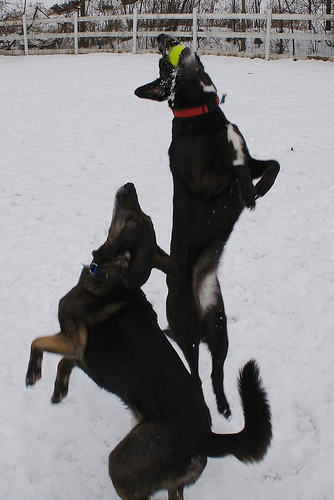

In [47]:
img =  Image.open("/kaggle/input/flickr8k/Images/"+test_sample.image.iloc[0]).convert("RGB")
img

In [48]:
features = feature_extractor(img, return_tensors="pt").pixel_values.to("cuda")
outputs = model.generate(features)[0]
generated_caption = tokenizer.decode(outputs)
generated_caption = "".join(generated_caption.split(".")[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


[CLS] two dogs playing with a tennis ball in the snow


In [50]:
def generate_captions(model, tokenizer, feature_extractor, test_dataset, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    generated_captions = []
    ground_truth_captions = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            pixel_values = batch['pixel_values'].to(device)
            outputs = model.generate(pixel_values)
            captions = [tokenizer.decode(output, skip_special_tokens=True).split('.')[0] for output in outputs]
            generated_captions.extend(captions)

            labels = batch['labels']
            for label in labels:
                label = label.cpu().numpy()
                label = [token if token != -100 else tokenizer.pad_token_id for token in label]
                decoded_caption = tokenizer.decode(label, skip_special_tokens=True)
                ground_truth_captions.append(decoded_caption)

    return generated_captions, ground_truth_captions

generated_captions, ground_truth_captions = generate_captions(model, tokenizer, feature_extractor, test_dataset)

100%|██████████| 64/64 [02:47<00:00,  2.61s/it]


In [51]:
!pip install git+https://github.com/salaniz/pycocoevalcap

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-ms72cs_z
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-ms72cs_z
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 9.4 MB/s eta 0:00:00:00:01
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=eb5a25e934fb345b34e881ea382a5a97fbab353c0534ca6ca55dc082c1b0f275
  Stored in directory: /tmp/pip-ephem-wheel-cache-h9rlnxyz/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [52]:
def calculate_metrics(generated_captions, ground_truth_captions):
    # Prepare the data in the required format
    gts = {i: [gt] for i, gt in enumerate(ground_truth_captions)}
    res = {i: [gen] for i, gen in enumerate(generated_captions)}

    # BLEU
    bleu_scorer = Bleu(n=4)
    bleu_scores, _ = bleu_scorer.compute_score(gts, res)

    # CIDEr
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(gts, res)

    # METEOR
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(gts, res)

    return {
        "BLEU-1": bleu_scores[0],
        "BLEU-2": bleu_scores[1],
        "BLEU-3": bleu_scores[2],
        "BLEU-4": bleu_scores[3],
        "CIDEr": cider_score,
        "METEOR": meteor_score,
    }

metrics = calculate_metrics(generated_captions, ground_truth_captions)
print(metrics)


{'testlen': 21782, 'reflen': 22369, 'guess': [21782, 19759, 17736, 15713], 'correct': [8567, 3178, 1264, 506]}
ratio: 0.9737583262550417
{'BLEU-1': 0.3828487851794598, 'BLEU-2': 0.24482526462329107, 'BLEU-3': 0.1608051819305258, 'BLEU-4': 0.10684936522338889, 'CIDEr': 0.8621411550694198, 'METEOR': 0.18875971618757928}


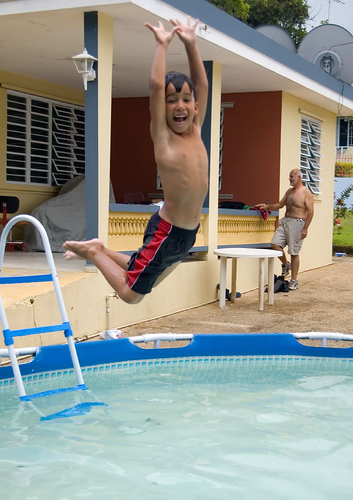

In [53]:
img =  Image.open("/kaggle/input/cccccc/indir (10).png").convert("RGB")
img

In [54]:
features = feature_extractor(img, return_tensors="pt").pixel_values.to("cuda")
outputs = model.generate(features)[0]
generated_caption = tokenizer.decode(outputs)
generated_caption = "".join(generated_caption.split(".")[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

[CLS] a child jumps into a swimming pool
